# This is the third step in reproducing the cluster analysis from Sara and David following Amini et al 2019
https://doi.org/10.1007/s00382-018-4409-7

This program:

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from scipy.signal import detrend

from eofs.multivariate.standard import MultivariateEof

### Define Input and Output Data

In [16]:
# Input
path='/project/predictability/kpegion/wxregimes/era-interim/'
fname='erai.z500_u250_pna_5dyrm_DJF.1980-2015.anoms.nc'

# Output
outfile='erai.z500_u250_pna_5dyrm_DJF.1980-2015.pcs.nc'

### Define constants

In [17]:
npcs=12

### Read Data

In [18]:
print(path+fname)
ds=xr.open_dataset(path+fname,decode_times=False)
ds['z500']=ds['z500']/9.81

nt=len(ds['time'])
nx=len(ds['lon'])
ny=len(ds['lat'])

ds

/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_DJF.1980-2015.anoms.nc


<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 3010)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 3003 3004 3005 3006 3007 3008 3009
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (time, lat, lon) float64 83.96 80.15 76.05 ... 12.98 12.89 13.99
    u250     (time, lat, lon) float64 ...

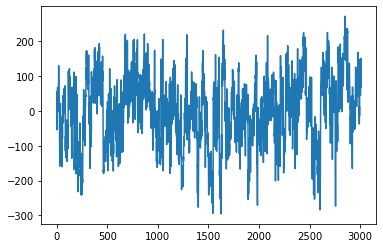

In [19]:
plt.plot(ds['z500'][:,12,25])

<xarray.DataArray 'u250' ()>
array(74.89558325)

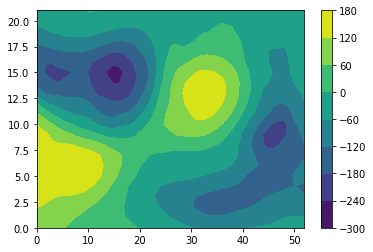

In [20]:
plt.contourf(ds['z500'][0,:,:])
plt.colorbar()

ds['z500'].var(dim='time').mean(dim=['lat','lon'])
ds['u250'].var(dim='time').mean(dim=['lat','lon'])

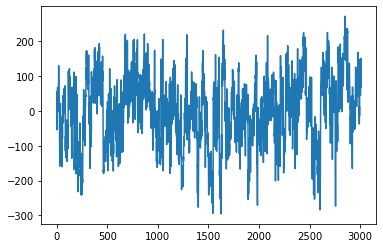

In [21]:
plt.plot(ds['z500'][:,12,25])

### Setup Latitude Weighting

In [22]:
coslat = np.cos(np.deg2rad(ds['lat'].values))
weights_array = np.sqrt(coslat)[:, np.newaxis]

### Do the latitude weighting myself first, then check nomalization

In [23]:
ds['z500']=ds['z500']*weights_array
ds['u250']=ds['u250']*weights_array

In [24]:
norm_z500=np.sqrt((ds['z500'].var(dim='time')).mean(dim=['lat','lon']))
ds['z500']=ds['z500']/norm_z500
norm_u250=np.sqrt(ds['u250'].var(dim='time').mean(dim=['lat','lon']))
ds['u250']=ds['u250']/norm_u250

In [25]:
print(norm_z500.values*norm_z500.values)
print(norm_u250.values*norm_u250.values)

3011.4084882772436
50.98274412599463


### Create the eof solver with latitude weighting

(12, 2332)
76.186944330306
(3010, 12)


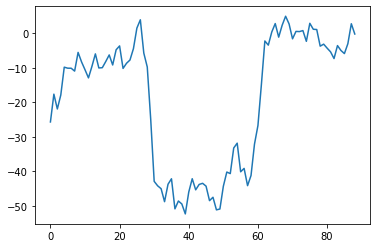

In [28]:
from sklearn.decomposition import PCA
neof=12

x1=ds['z500'].values.reshape((nt,nx*ny))
x2=ds['u250'].values.reshape((nt,nx*ny))
X=np.hstack([x1,x2])

X=detrend(X,axis=0)
pca = PCA(n_components=neof, svd_solver='full')
pca.fit(X)
print(pca.components_.shape)
eof = pca.components_.reshape((neof,2,ny,nx))

#pcatmp=eof
#pcatmp[:,0,:,:]=pcatmp[:,0,:,:]/norm_z500.values
#pcatmp[:,1,:,:]=pcatmp[:,1,:,:]/norm_u250.values
#pcatmp=pcatmp.reshape(neof,2*nx*ny)

#print(pcatmp.shape)

pc=np.dot(X,np.transpose(pca.components_)).squeeze()
L=(pca.explained_variance_ratio_)*100 
print(sum(L))

print(pc.shape)
plt.plot(pc[0:89,0])


#    PCS[:,ilead]=pc/np.std(pc)
#    EOFS[:,:,ilead]=eof[:,:]/np.std(eof)
#    print(np.std(pc))
    
#for i in range(ny):
#    lweight=np.sqrt(np.abs(np.cos(np.radians(naoreg['lat'][i].values))))
#    EOFS[i,:,:]=EOFS[i,:,:]/lweight

In [29]:
print(nx*ny*2)

2332


### Get the EOF (spatial pattern) as a check

### Plot the first EOF (spatial pattern) as a check; should be Aleutian Low associated with ENSO

In [30]:
cm = 180
proj = ccrs.PlateCarree(central_longitude=cm)
minlon = -30 + cm
maxlon = +120 + cm
lat_labels=np.arange(20,80,20)
lon_labels=np.arange(150,330,30)
extent=[minlon,maxlon,20,80]

In [31]:
levs=np.arange(-0.1,0.07,0.02)
z500_eof1=eof1_list[0][0,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               eof[0,0,:,:],levs,
               transform=ccrs.PlateCarree(),
              extend='both')
ax.set_title('EOF1 z500')
ax.coastlines()
plt.colorbar(cs)

NameError: name 'eof1_list' is not defined

In [ ]:
levs=np.arange(-0.045,0.1,0.015)
u250_eof1=eof1_list[1][0,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               eof[0,1,:,:],levs,
               transform=ccrs.PlateCarree(),
               extend='both')
ax.set_title('EOF1 u250')
ax.coastlines()
plt.colorbar(cs)

In [ ]:
levs=np.arange(-0.06,0.08,0.02)
z500_eof2=eof1_list[0][1,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               eof[1,0,:,:],levs,
               transform=ccrs.PlateCarree(),
               extend='both')
ax.set_title('EOF2 z500')
ax.coastlines()
plt.colorbar(cs)

In [ ]:
levs=np.arange(-0.075,0.07,0.015)
u250_eof2=eof1_list[1][1,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               eof[1,1,:,:],levs,
               transform=ccrs.PlateCarree())
ax.set_title('EOF2 u250')
ax.coastlines()
plt.colorbar(cs)

### Get the First 12 PCs

In [ ]:
pcs = solver.pcs()
pcs = solver.pcs(npcs=npcs, pcscaling=0)
#pcs = solver.pcs(npcs=npcs)
pcs.shape

In [ ]:
weights_array

In [32]:
plt.plot(pcs[0:89,0])
print(pcs[:,0].mean())
print(pcs[:,0].std())
print(pcs[:,0].var())

NameError: name 'pcs' is not defined

### Find out how much variance is explained by first 12 PCs; Amini and Straus found about 80%

In [26]:
variance_fractions = solver.varianceFraction(neigs=npcs)

In [27]:
variance_fractions.sum()

0.7658855797850364

### Put PCs into `xr.Dataset`

In [23]:
# Create a new xarray dataset for z500
pcs_ds=xr.DataArray(pcs,
                    coords={'time': ds['time'].values,
                            'pcnum':np.arange(npcs)},
                            dims=['time','pcnum'])        
pcs_ds=pcs_ds.to_dataset(name='pcs')

ValueError: conflicting sizes for dimension 'pcnum': length 1 on the data but length 12 on coordinate 'pcnum'

In [ ]:
pcs_ds

In [ ]:
pcs_ds.to_netcdf(path+outfile)